# Redes Neurais Artificiais

## Fase Forward + Backward + Activation Fanctions

Conforme definições em sala de aula, temos abaixo a criação de datasets auxiliares, funções para plotar os gráficos, definições de funções de custo, definições dos algoritmos da rede. Por fim, a classe MLP que implementa uma "casca" para chamada dos algoritmos de treinamento.

Nas atividades anteriores implementamos a fase Forward (https://github.com/pablosnascimento/disciplina_rn/blob/main/atividades_avaliativas/MLP_foward_fixedweigths.ipynb) e a backward (https://github.com/pablosnascimento/disciplina_rn/blob/main/atividades_avaliativas/MLP_backward.ipynb)

Nesta atividade, implementaremos um complemento à fase Backward adicionado as funções de ativação Sigmoid, Tanh e ReLU.

#### Geração de bases de dados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize
from scipy.special import expit

margem = 0.1

def criaDatasetXOR(n=1000):
    '''
    Cria dataset XOR, não linearmente separável.
    Será necessária uma camada oculta para resolver. 
    '''
    X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
    y = np.array(y%2,dtype=int)
    return X,y

def criaDatasetXOR_Multiclasse(n=20, n_classes=3):
    '''
    Cria dataset XOR, não linearmente separável.
    Mesmo do anterior, mas com varias classes
    '''
    X,y = make_blobs(n_samples=n,
                     centers=n_classes**2,
                     cluster_std=0.8)
    y = np.array(y%n_classes,dtype=int)
    return X,y

# Funções de plot

In [2]:
def plotDataSet(X,y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    for k in set(y):
        #print("k=",k)
        plt.plot(X[:,0][y==k],
                 X[:,1][y==k],
                 "o",alpha=0.3)

def plotHiperplano(X,y,vetor, intercept=0):
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    
    xs = np.linspace(x0min, x0max, num=2)
    #separador do hiperplano entre duas classificações pode ser 
    #encontrada conforme calculo abaixo:
    ys = (-vetor[0]/vetor[1])*xs-intercept/vetor[1]
    plt.plot(xs,ys)

Quanto temos uma situação em que a solução não é linearmente separável, precisamos criar uma camada oculta com pelo menos 2 neuronios, cuja função de ativação seja não linear.

Vamos criar uma nova função de plot para mostrar as regiões e não exatamente os pontos.

In [3]:
def define_axes(X):
    '''
    A função retorna os eixos com a margem de 0.1
    O vetor será o mínimo até o máximo de cada um; esses são os eixos em que faremos a distribuição.
    '''
    #o mínimo e máximo da característica 1
    min1 = X[:,0].min()
    max1 = X[:,0].max() 

    min2 = X[:,1].min()
    max2 = X[:,1].max() 

    #colocando margem para baixo e margem pra cima de 10%
    return [min1-margem, max1+margem, min2-margem, max2+margem] #margem idel é .1 é o mesmo que 0.1

def plotPredictions(clf, X):
    '''
    Recebe um classificador e a matriz de características e exibe um gráfico utilizando meshgrid.
    '''
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0,x1 = np.meshgrid(x0s, x1s) #está fazendo a distribuição nxn, gerando duas matrizes
    X_ = np.c_[x0.ravel(), x1.ravel()] #c_ = cópia
    ypred  = clf.predict(X_).reshape(x0.shape)
    plt.contourf(x0,x1,ypred,cmap=plt.cm.brg, alpha=0.2)

Testando um classificador qualquer com a base XOR definida no início.

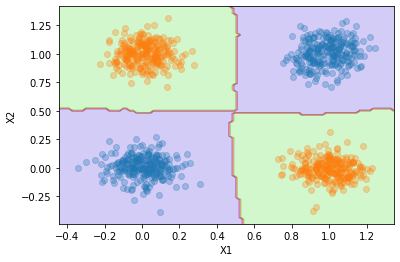

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit

def tanh(a):
    '''
    Definição da tangente hiperbólica.
    '''
    return expit(a)*2-1

X,y = criaDatasetXOR()

knn = KNeighborsClassifier()
knn.fit(X,y)

plotDataSet(X,y)
plotPredictions(knn, X)


A seguir, criaremos uma classe inicial para definição do algoritmo de treinamento apenas com a fase forward (predict básico).

Criando a classe MLP, genérica, que herda de BaseEstimator e ClassifierMixin para casca do algoritmos de treinamento da rede. Esta classe recebe um algoritmo de treinamento como parâmetro que, neste caso, será a classe FixedWeights. A classe FixedWeights possui os pesos de entrada e saída da camada oculta definidos ainda de forma "manual" (experimental).

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

def includeBias(X):
    bias = np.ones((X.shape[0], 1))
    Xb = np.concatenate((bias, X), axis=1)
    return Xb

class FixedWeigths():
    '''
    Utilizaremos inicialmente a quantidade mínima de camadas intermediárias para resolver o problema do XOR.
    ou seja, n_hidden=2
    '''
    def __init__(self):
        self.n_hidden = 2
        self.activation = tanh #utilizando a função tangente hiperbolica

    def fit(self, X, y):
        '''
        Os pesos definidos aqui foram esperimentalmente definidos.
        Podemos, no entanto, treinar esses pesos. Por exemplo, utilizar a PseudoInversa ou DescidaGradiente para obter esses valores; faremos isso nas próximas atividades.
        '''
        #coeficientes da camada de entrada da camada oculta
        #Teremos uma matriz 3x2 com a camada de dentrada 
        self.wih = np.array([[1.75, 0.9, -0.9],[-1.75, 0.9, -0.9]]).T #3x2, valores ok, linhas paralelas no grafico impresso

        #coeficientes da camada de saída da camada oculta
        self.who = np.array([1.234, -0.9, 0.9]) #antes com exemplo de pesos fixos definidos "manualmente" (porque foram levemente testados antes)

    def predict(self, X, y=None):
        #incluindo o bias na camada intermediaria
        Xb = includeBias(X)
        
        #aplica a funçao de ativação na camada oculta
        H = self.activation(Xb @ self.wih)

        #incluindo o bias tambem na camada 'oculta'. Poruqe ele irá incluir o bias em todas as camadas e mais pra frente irá fazer isso com loop
        Hb = includeBias(H)
        return Hb @ self.who

class MLP(BaseEstimator, ClassifierMixin):
    '''
    Rede neural que será genérico para chamarmos os demais passando apenas o algoritmo de treinamento.
    '''
    def __init__(self, training_algorithm=FixedWeigths()):
        self.training_algorithm = training_algorithm
    
    def encode_labels(self, y):
        self.labels = list(set(y))
        return label_binarize(y, classes=self.labels)*2-1 #tudo entre -1 e 1
    
    def fit(self, X, y):
        yhot = self.encode_labels(y)
        self.training_algorithm.fit(X, yhot)
    
    def predict(self, X, y=None):
        a = self.training_algorithm.predict(X)

        if len(self.labels) <= 2:
            idx = np.array(a>0, dtype=int).reshape((-1,))
        else:
            idx = np.argmax(a, axis=1)
        
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

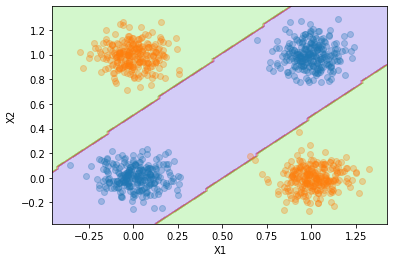

In [6]:
'''
Executando o MLP: 
- pesos fixos (sem treinamento para definição dos coeficientes de entrada)
- apenas fase forward
- sem divisão de treino e teste
'''
margem = 0.1 #alterando essa margem a imagem do plotPrediction é mostrada de uma dimensão diferente
X,y = criaDatasetXOR(n=1000)

mlp = MLP()
mlp.fit(X, y)
ypred = mlp.predict(X)

plotDataSet(X,y)
plotPredictions(mlp, X)


Já observamos que foi possível tratar o problema de uma base de dados linearmente não separável.
Até este ponto trabalhamos o Forward. Ou seja, tratamos o caminho de calculo da entrada em direção à saída utilizando pesos fixos nos coeficientes (encontrados experimentalmente ainda sem treinamento).

Nas próximas atividades, nós iremos voltar no sentido contrário (backward). Partiremos da última camada de saída e calculando os pesos intermediários buscaremos minimizar o erro e encontrar pesos melhores. O algoritmo de treinamento que trata essa volta é chamado de BackPropagation.

## Fase Backward

Para implementação da fase Backward, criaremos uma classe de treinamento com este nome. Esta classe tem a fase Forward (naturalmente, pois é o primeiro fluxo do algoritmo) e também possui a fase Backward. 

A fase Backward é o que nos dá poder para criarmos um fluxo inteligente de interações na rede indo e voltando ajustando cada vez mais os pesos para melhores resultados. Vamos, então, à sua definição.

In [7]:
class Backpropagation():
    '''
    Algoritmo de treinamento que será utilizado na volta para descoberta dos pesos da camada hidden H.
    '''
    def __init__(self):
        self.n_hidden = 2
        self.activation = tanh
        self.learning_rate = 0.005
        self.max_iter = 1000

    def fit(self, X, y):
        self.Xb = includeBias(X)
        #definindo pesos aleatorios
        self.wih = np.random.uniform(-1, 1, size=(self.Xb.shape[1],self.n_hidden)) #matrix com Xb.shape linhas e n_hidden colunas
        self.who = np.random.uniform(-1, 1, size=(self.n_hidden+1, y.shape[1])) #matrix 

        #a ideia aqui é iterar indo e voltando na rede e treinando para encontrar os pesos.
        #a cada iteração um ciclo completo é calculado.
        for _ in range(self.max_iter):
            self.forward()
            self.backward(y)

    def forward(self):
        #pH -> preactivation na camada hidden
        Xb = self.Xb
        self.pH = Xb @ self.wih
        self.H = self.activation(self.pH)
        self.Hb = includeBias(self.H)
        self.py = self.Hb @ self.who

    def backward(self, y):
        ho_delta = y - self.py
        #gradiente de saída da camada H
        ho_grad = self.Hb.T @ ho_delta

        #pulo do gato
        #função da tangente hiperbolica equivalente a (1 - tanh(H)²), ou (1 - H²)
        #derivada da função de ativação. Nesse ponto é preciso conhecer sempre a função de ativação pra que sua derivada seja usada no backpropagation
        tanh_grad = (1 - np.square(tanh(self.pH))) 
        ih_delta = (ho_delta @ self.who[1:,:].T)*tanh_grad #self.who precisou tirar o bias, pois na volta ele não existe na camada

        ih_grad = self.Xb.T @ ih_delta

        self.who += ho_grad * self.learning_rate
        self.wih += ih_grad * self.learning_rate

    def predict(self, X, y=None):
        '''
        Predict definido igual ao FixedWeigths, é foward, então, segue o mesmo algoritmo.
        '''
        #incluindo o bias na camada intermediaria
        Xb = includeBias(X)
        
        #aplica a funçao de ativação na camada oculta
        H = self.activation(Xb @ self.wih)

        #incluindo o bias tambem na camada 'oculta'. Porque ele irá incluir o bias em todas as camadas e mais pra frente irá fazer isso com loop
        Hb = includeBias(H)
        return Hb @ self.who

wih= [[ 5.28902048 -2.51818017]
 [-4.03530387  3.32776453]
 [-4.04190669  3.31859775]]
who= [[-1.29642838]
 [ 2.50688424]
 [ 2.59196081]]


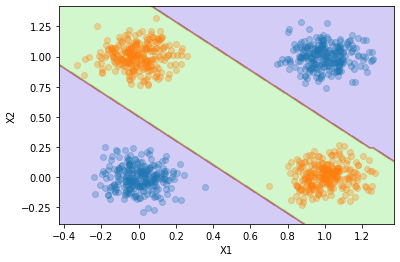

In [8]:
'''
Executando o MLP: 
- treinando os pesos no forward
- implementando fase backward
- aplicando divisão de treino e teste
'''
from sklearn.model_selection import train_test_split

X,y = criaDatasetXOR(n=1000)

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.9)

mlp = MLP(training_algorithm=Backpropagation())
mlp.fit(Xtr,ytr)
ypred = mlp.predict(Xte)

plotDataSet(X,y)
plotPredictions(mlp, Xte)

#imprimindo os pesos dos ws para conhecê-los:
print('wih=',mlp.training_algorithm.wih)
print('who=',mlp.training_algorithm.who)


## Activation Functions

Vamos criar algumas funções de ativação e depois ajustar a classe para recebê-la como parâmetro.

In [14]:
from abc import ABC, abstractmethod, abstractstaticmethod

def sign(a):
    return (a >= 0)*2-1

def accuracy(yactual, ypred):
    return sum(yactual==ypred)/len(yactual)

class ActivationFunction(ABC):
    @abstractstaticmethod
    def forward(a):
        pass

    @abstractstaticmethod
    def backward(a):
        pass

    @abstractstaticmethod
    def decision(a):
        '''        
        A principio, a função de ativação retorna um valor real, mas aqui tratamos o retorno para 0 ou 1 (ou 1 e -1)
        '''
        pass

#Herda a classe e define o foward, backward e o decision. 
#Cada uma nova função de ativação basta implementar conforme esse padrão.
class Tanh(ActivationFunction):
    '''
    Definição da Função Hiperbólica como função de ativação. 
    '''
    @staticmethod
    def forward(a):
        return expit(a)*2-1 #tangente hiperbolica
    
    @staticmethod
    def backward(a):
        return (1 - np.square(Tanh.forward(a))) #confore ultimo quadro da tarefa

    @staticmethod
    def decision(a):
        return (a >= 0.0) * 2 - 1

class Sigmoid(ActivationFunction):
    @staticmethod
    def forward(a):
        return expit(a)
    
    @staticmethod
    def backward(a):
        return Sigmoid.forward(a) * (1 - Sigmoid.forward(a))
    
    @staticmethod
    def decision(a):
        return (a >= 0.5) * 2 - 1

class ReLU(ActivationFunction):
    @staticmethod
    def forward(a):
        return a * (a > 0)
    @staticmethod
    def backward(a):
        return (a > 0).astype(np.int8)

    @staticmethod
    def decision(a):
        return (a>=0)*2-1

#redefinindo o Backward para receber generalização sobre a função de ativação
class Backpropagation():
    def __init__(self, n_hidden=5, max_iter=1000, learning_rate=0.005, activation=Tanh()):
        self.n_hidden = n_hidden
        self.activation = activation
        self.learning_rate = learning_rate
        self.max_iter = max_iter
    
    def forward(self, X):
        self.Xb = includeBias(X)
        self.pH = self.Xb @ self.ihw
        self.H = self.activation.forward(self.pH)

        self.Hb = includeBias(self.H)
        self.prey = self.Hb @ self.how
        self.posy = self.activation.forward(self.prey)
        self.ypred = self.activation.decision(self.posy)

    def backward(self, y):
        ho_delta = y - self.ypred
        ho_grad = self.Hb.T @ ho_delta
        deriv_grad = self.activation.backward(self.pH) 

        ih_delta = (ho_delta @ self.how[1:,:].T) * deriv_grad
        ih_grad = self.Xb.T @ ih_delta
        self.how += ho_grad * self.learning_rate
        self.ihw += ih_grad * self.learning_rate
    
    def fit(self, X, y):
        self.ihw = np.random.uniform(-1, 1, size=(X.shape[1]+1, self.n_hidden))
        self.how = np.random.uniform(-1, 1, size=(self.n_hidden+1, y.shape[1]))

        for _ in range(self.max_iter):
            self.forward(X)
            self.backward(y)
    
    def predict(self, X):
        Xb = includeBias(X)
        pH = Xb @ self.ihw
        H = self.activation.forward(pH)
        
        Hb = includeBias(H)
        prey = Hb @ self.how
        posy = self.activation.forward(prey)
        return self.activation.decision(posy)

Função Tanh
1.0
0.89


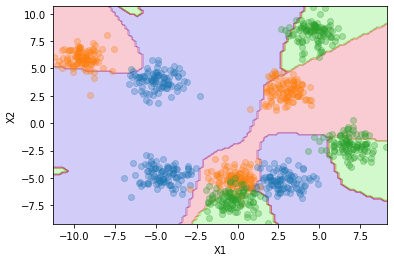

Função Sigmoid
1.0
0.8455555555555555


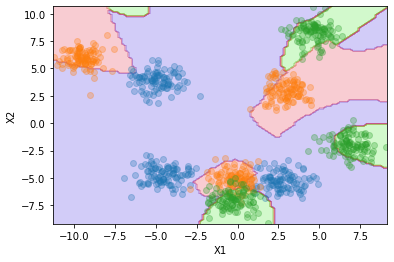

Função ReLU
1.0
0.8666666666666667


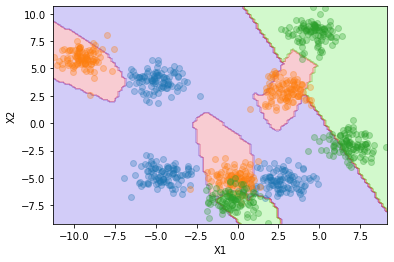

In [22]:
'''
Executando o MLP: 
- treinando os pesos no forward
- implementando fase backward
- funções de ativação
- aplicando divisão de treino e teste
'''
import warnings
warnings.filterwarnings("ignore")

funcoes = [Tanh(), Sigmoid(), ReLU()]
funcNames = ['Tanh', 'Sigmoid', 'ReLU']
X,y = criaDatasetXOR_Multiclasse(n=1000, n_classes=3)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

i=0
for funcao in funcoes:
    mlp = MLP(training_algorithm=Backpropagation(n_hidden=16, learning_rate=0.0009, max_iter=10000, activation=funcao))
    mlp.fit(Xtr,ytr)
    print("Função " + funcNames[i])
    print(accuracy(ytr, mlp.predict(Xtr)))
    print(accuracy(yte, mlp.predict(Xte)))

    plotDataSet(Xte,yte)
    plotPredictions(mlp, Xte)
    plt.show()

    i += 1

Podemos observar que as três funções de ativação funcionaram bem para o exemplo nesta base de dados com 3 blobs de cada grupo e 16 neurônibos na camada oculta.